# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

### 1.1 Loading the dataset

In [46]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob
import time
from torch.nn import init
import torch.nn as nn


from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
import torch.optim as optim


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        # 
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [47]:
class Up_Sample_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Up_Sample_Conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2), # Nearest neighbour for upsampling are two 
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

    
class Repeat(nn.Module):
    def __init__(self, ch_out):
        super(Repeat, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)) 
#Inplace has been set to TRUE so that it modifies the input directly, without allocating any additional output.

    def forward(self, x):
        for i in range(2):
            if i == 0:
                x_rec = self.conv(x)
            x_rec = self.conv(x + x_rec)
        return x_rec

class RR_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RR_Conv, self).__init__()
        self.Repeat_block = nn.Sequential(Repeat(ch_out),Repeat(ch_out))
        self.Conv = nn.Conv2d(ch_in, ch_out, 1, 1, 0)

    def forward(self, input_img):
        input_img = self.Conv(input_img)
        conv_input_img = self.Repeat_block(input_img)
        return input_img + conv_input_img 
    
############
############

class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=19):
        super(R2U_Net, self).__init__()
        
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.channel_1 = 64 # R2U-net activation maps in first layer
        self.channel_2 = 2*self.channel_1
        self.channel_3 = 2*self.channel_2
        self.channel_4 = 2*self.channel_3
        self.channel_5 = 2*self.channel_4
        
        self.channels = [self.channel_1, self.channel_2, self.channel_3, self.channel_4, self.channel_5]
            
        '''Performs Convolution and responsible for the encoding part of the architecture'''    
        self.Layer1 = RR_Conv(img_ch, self.channels[0])
        self.Layer2 = RR_Conv(self.channels[0], self.channels[1])
        self.Layer3 = RR_Conv(self.channels[1], self.channels[2])
        self.Layer4 = RR_Conv(self.channels[2], self.channels[3])
        self.Layer5 = RR_Conv(self.channels[3], self.channels[4])

        '''Below function calls are responsible for the decoding part of the architeture'''
        
        '''Upsamples the input and then performs convolution followed by ReLU'''
        self.DeConvLayer5 = Up_Sample_Conv(self.channels[4], self.channels[3])
        self.DeConvLayer4 = Up_Sample_Conv(self.channels[3],self.channels[2])
        self.DeConvLayer3 = Up_Sample_Conv(self.channels[2], self.channels[1])
        self.DeConvLayer2 = Up_Sample_Conv(self.channels[1], self.channels[0])
        
        '''Responsible for computation in Recurrent Residual Blocks'''
        self.Up_Layer5 = RR_Conv(self.channels[4], self.channels[3])
        self.Up_Layer4 = RR_Conv(self.channels[3], self.channels[2])
        self.Up_Layer3 = RR_Conv(self.channels[2], self.channels[1])
        self.Up_Layer2 = RR_Conv(self.channels[1], self.channels[0])
        
        '''Final output of the architecture needs to have output channels=number of class labels(19)'''
        self.Conv = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1, padding=0)        
        
    def forward(self, x):
        '''Recurrent Convolution'''
        conv1 = self.Layer1(x)
        mp1 = self.MaxPool(conv1)
        conv2 = self.Layer2(mp1)
        mp2 = self.MaxPool(conv2)
        conv3 = self.Layer3(mp2)
        mp3 = self.MaxPool(conv3)
        conv4 = self.Layer4(mp3)
        mp4 = self.MaxPool(conv4)
        conv5 = self.Layer5(mp4)

        ''' 
        Decoder part of the architecture which performs 
        Recurrent up convolution as well as concatention from previous layers 
        '''
        deconv5 = self.DeConvLayer5(conv5)
        deconv5 = torch.cat((conv4, deconv5), dim=1)
        deconv5 = self.Up_Layer5(deconv5)
        deconv4 = self.DeConvLayer4(deconv5)
        deconv4 = torch.cat((conv3, deconv4), dim=1)
        deconv4 = self.Up_Layer4(deconv4)
        deconv3 = self.DeConvLayer3(deconv4)
        deconv3 = torch.cat((conv2, deconv3), dim=1)
        deconv3 = self.Up_Layer3(deconv3)
        deconv2 = self.DeConvLayer2(deconv3)
        deconv2 = torch.cat((conv1, deconv2), dim=1)
        deconv2 = self.Up_Layer2(deconv2)
        deconv1 = self.Conv(deconv2)

        return deconv1

In [48]:
model = R2U_Net()

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [49]:
data_path = "/raid14/VOCdevkit/VOC2012/"

train_epochs = 11
batch_size = 2
num_workers = 2

learning_rate = 5.0e-4

'''Number of classes'''
n_classes = 21

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [50]:
'''Datasets instances - Training and Validation'''
train_set = pascalVOCDataset(
    data_path,
    is_transform=True,
    split="train")

val_set = pascalVOCDataset(
    data_path,
    is_transform=True,
    split="val")

'''Dataloaders'''
train_loader = data.DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle=True,
    num_workers = num_workers)

val_loader = data.DataLoader(
    val_set,
    batch_size = batch_size,
    num_workers = num_workers)

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [51]:
loss_f = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), learning_rate)

### 1.6 Evaluate your model(1.5 points) -- [Order of Section 1.6 and section 1.7 has been interchanged]
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [52]:
'''
Calculation of confusion matrix from :
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/metrics.py

Added modifications to calculate 5 different evaluation metrics - 
Specificity, Senstivity, F1 Score, Accuracy, Jaccard Score
'''

#      True values
#         0    1    2
#    0   TP   FP   FP
#    1   FN   TN   TN       This is wrt to class 0
#    2   FN   TN   TN
   
#         0    1    2
#    0   TP   FP   FP
#  P 1   FP   TP   FP       This is wrt prediction classes; AXIS = 1
#    2   FP   FP   TP 
   
#         0    1    2
#    0   TP   FN   FN
#    1   FN   TP   FN       This is wrt true classes; AXIS = 0
#    2   FN   FN   TP  

import sklearn.metrics as skm

def get_metrics_sh(gt_label, pred_label):
    #Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)
    #Jaccard Score/IoU
    js = skm.jaccard_score(gt_label, pred_label, average='micro')   
    result_gm_sh = [acc, js]
    return(result_gm_sh)

class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        # confusion matrix
        hist = self.confusion_matrix
        
        TP = np.diag(hist)
        TN = hist.sum() - hist.sum(axis = 1) - hist.sum(axis = 0) + np.diag(hist)
        FP = hist.sum(axis = 1) - TP
        FN = hist.sum(axis = 0) - TP
        
        # Specificity: TN / TN + FP
        specif_cls = (TN) / (TN + FP + 1e-6)
        specif = np.nanmean(specif_cls)
        
        # Senstivity/Recall: TP / TP + FN
        sensti_cls = (TP) / (TP + FN + 1e-6)
        sensti = np.nanmean(sensti_cls)
        
        # Precision: TP / (TP + FP)
        prec_cls = (TP) / (TP + FP + 1e-6)
        prec = np.nanmean(prec_cls)
        
        # F1 = 2 * Precision * Recall / Precision + Recall
        f1 = (2 * prec * sensti) / (prec + sensti + 1e-6)
        
        return (
            {
                "Specificity": specif,
                "Senstivity": sensti,
                "F1": f1,
            }
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

### 1.7 Training the model(3.0 points) -- [Order of Section 1.6 and Section 1.7 has been interchanged]
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:7')
model.to(device)

'''
This function trains the model and is running in the main loop
[param_in] : trainloader : Instance of Dataloader for training dataset
[param_in] : model : Instance of neural network model
[param_in] : loss_fn : Loss function being used for the model 
[param_in] : optimizer : Optimizer being used for the model
[param_in] : epoch : Epoch index currently running 
[param_in] : epoch_total : Total number of epochs to train the model

[param_out]: None
'''
def train(trainloader, model, loss_fn, optimizer, epoch, epoch_total):
        count = 0
        '''Iterates over each image in training dataset one by one'''
        for (images, labels) in trainloader:
            count += 1 
            model.train()

            '''Transfer the images and labels to GPU for training'''
            images = images.to(device)
            labels = labels.to(device)

            '''Feeds the input images to the model for forward pass'''
            pred = model(images)

            '''Calculates the loss of the prediction with the target label'''
            loss = loss_fn(pred, labels)

            '''
            1. zero_grad: Makes the gradients equal to zero before performing the back propogation to clear the history
            2. backward: Performs the backward propogation and calculates the gradients
            3. step: The optimizer updated the weights as per the computation performed during backward propogation
            '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
'''
This function tests the model on validation set and is runs after each training epoch
[param_in] : valloader : Instance of Dataloader for validation dataset
[param_in] : model : Instance of neural network model
[param_in] : loss_fn : Loss function being used for the model 

[param_out]: score : Metrics Scores
'''
def test_loop(valloader, model, loss_fn):
    model.eval()
    running_metrics_val = runningScore(n_classes)
    
    accuracy_lst = []
    jaccard_lst = []

    with torch.no_grad():
        for i_val, (images_val, labels_val) in tqdm(enumerate(valloader)):
            images_val = images_val.to(device)
            labels_val = labels_val.to(device)

            val_pred = model(images_val)

            pred = val_pred.data.max(1)[1].cpu().numpy()
            gt = labels_val.data.cpu().numpy()
            
            '''To update - sensitivity, specificity and F1 scores in the list for prediction of every image'''
            running_metrics_val.update(gt, pred)
            
            '''To fetch accuracy and jaccard score for prediction of every image'''
            acc_jaccard_metrics = get_metrics_sh(gt.flatten(), pred.flatten())
            accuracy_lst.append(acc_jaccard_metrics[0])
            jaccard_lst.append(acc_jaccard_metrics[1])   

    '''contains senstivity, specificity and F1 scores'''
    score = running_metrics_val.get_scores()
    running_metrics_val.reset()
    
    accuracy = sum(accuracy_lst)/len(accuracy_lst)
    jaccard = sum(jaccard_lst)/len(jaccard_lst)
    
    '''Append Acuracy and Jaccard score in the running metrics list to make a single list of all metrics'''
    score["Accuracy"] = accuracy
    score["Jaccard"] = jaccard

    return(score)

'''
This is the main loop which trains and then test the model on training and validation datasets 
'''
if __name__ == "__main__":
    train_acc = []
    val_acc = []
    
    accuracy_lst = []
    jaccard_lst = []
    specificity_lst = []
    senstivity_lst = []
    f1_lst = []
    
    for t in range(train_epochs):
        '''Starting time for reference'''
        t1 = time.time()
        
        '''Start the training of the model'''
        train(train_loader, model, loss_f, optimiser, t, train_epochs)
        '''t2 : Time taken to train the model in 1 epoch'''
        t2 = time.time()
        print("It took: ", t2-t1, "seconds to complete one training epoch")
        
        '''Test the model on training dataset'''
        print("Testing the model on training dataset...")
        train_scores = test_loop(train_loader, model, loss_f)
        
        accuracy_lst.append(train_scores["Accuracy"])
        jaccard_lst.append(train_scores["Jaccard"])
        specificity_lst.append(train_scores["Specificity"])
        senstivity_lst.append(train_scores["Senstivity"])
        f1_lst.append(train_scores["F1"])
        
        '''Test the model on validation dataset'''
        print("Testing the model on validation dataset...")
        val_acc.append(test_loop(val_loader, model, loss_f))
        
    print("Done!")

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.


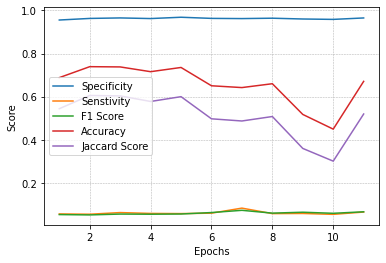

In [70]:
plt.clf()
x = [i for i in range(1, train_epochs + 1)]

plt.plot(x,specificity_lst, label='Specificity')
plt.plot(x,senstivity_lst, label='Senstivity')
plt.plot(x,f1_lst, label='F1 Score')
plt.plot(x,accuracy_lst, label='Accuracy')
plt.plot(x,jaccard_lst, label='Jaccard Score')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

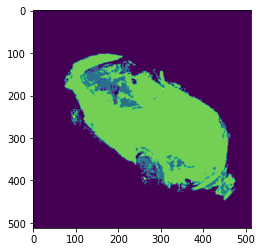

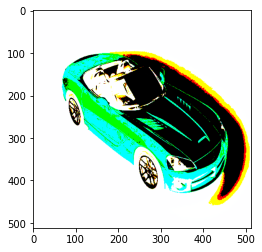

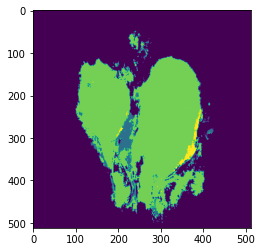

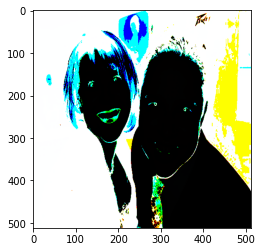

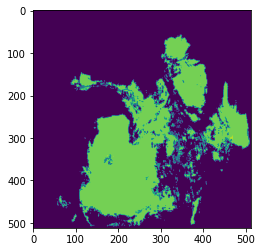

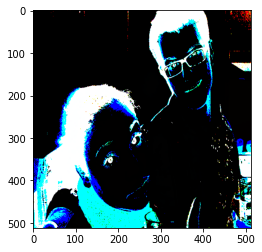

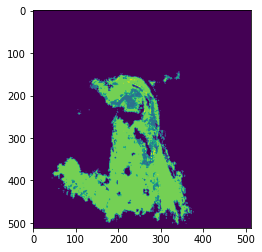

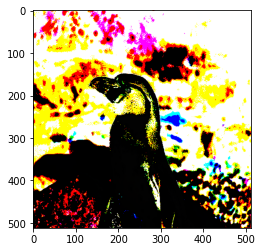

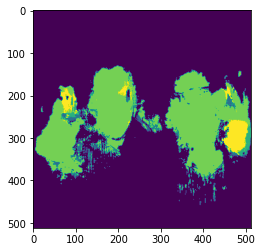

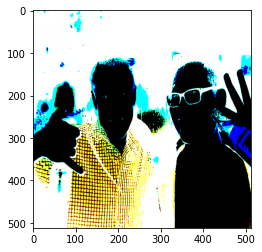

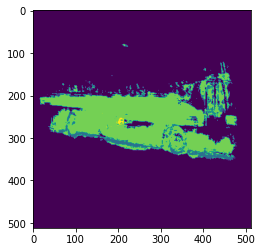

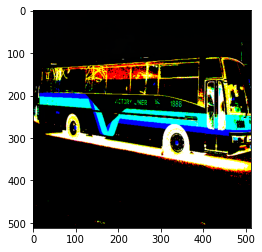

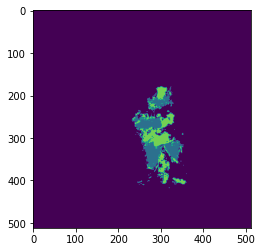

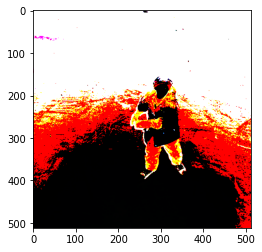

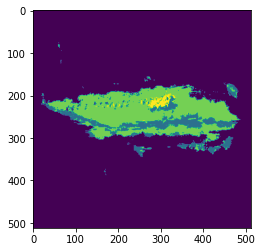

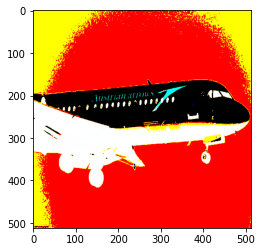

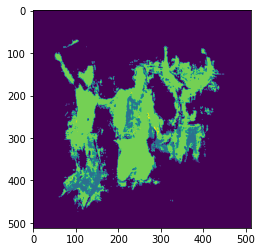

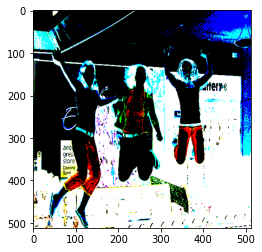

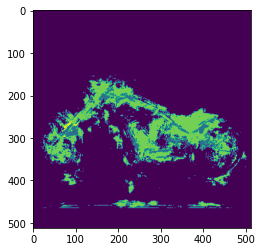

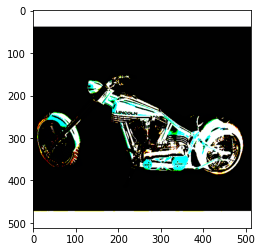

In [67]:
import random

'''Randomly samples 10 images form first 500 images in dataset'''
plot_img = random.sample(range(1,500), 10)
model.eval()

with torch.no_grad():
    for image_index, (images_val, labels_val) in enumerate(val_loader):
        images_val = images_val.to(device)
        labels_val = labels_val.to(device)

        val_pred = model(images_val)

        pred = val_pred.data.max(1)[1].cpu().numpy()
        gt = images_val.data.cpu().numpy()

        if image_index in plot_img:
            plt.imshow(pred[0])
            plt.show()
            plt.clf()
            img_plt = np.transpose(gt[0],(1,2,0))
            plt.imshow(np.uint8(img_plt))
            plt.show()